In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU


In [ ]:
#Cargar los datos
company = '^MXX'
ticker = yf.Ticker(company)
hist = ticker.history(start = '2000-1-1', end='2024-4-10')

hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-06:00,7185.709961,7278.770020,7059.450195,7077.709961,0,0.0,0.0
2000-01-04 00:00:00-06:00,7074.709961,7074.709961,6673.359863,6675.270020,0,0.0,0.0
2000-01-05 00:00:00-06:00,6674.930176,6781.029785,6524.279785,6764.310059,0,0.0,0.0
2000-01-06 00:00:00-06:00,6784.000000,6822.459961,6742.910156,6751.649902,0,0.0,0.0
2000-01-07 00:00:00-06:00,6768.859863,7054.290039,6768.859863,7047.089844,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-03 00:00:00-06:00,57547.191406,58086.421875,57300.109375,57503.390625,189285300,0.0,0.0
2024-04-04 00:00:00-06:00,57539.468750,58219.500000,57514.179688,57882.761719,184739700,0.0,0.0
2024-04-05 00:00:00-06:00,57805.191406,58227.839844,57678.609375,58092.441406,212252300,0.0,0.0


In [ ]:
#Preparar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(hist['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(6031, 60, 1)

In [ ]:
#Construir el modelo
model = Sequential()

model.add(GRU(units=50,return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train,epochs=25,batch_size=32)


Epoch 1/25
189/189 [==============================] - 23s 92ms/step - loss: 0.0090
Epoch 2/25
189/189 [==============================] - 17s 91ms/step - loss: 0.0021
Epoch 3/25
189/189 [==============================] - 17s 88ms/step - loss: 0.0016
Epoch 4/25
189/189 [==============================] - 17s 88ms/step - loss: 0.0014
Epoch 5/25
189/189 [==============================] - 18s 94ms/step - loss: 0.0013
Epoch 6/25
189/189 [==============================] - 17s 88ms/step - loss: 0.0012
Epoch 7/25
189/189 [==============================] - 17s 89ms/step - loss: 0.0012
Epoch 8/25
189/189 [==============================] - 18s 96ms/step - loss: 0.0011
Epoch 9/25
189/189 [==============================] - 17s 90ms/step - loss: 0.0011
Epoch 10/25
189/189 [==============================] - 17s 89ms/step - loss: 0.0011
Epoch 11/25
189/189 [==============================] - 18s 94ms/step - loss: 0.0011
Epoch 12/25
189/189 [==============================] - 17s 88ms/step - loss: 9.9678e-

In [ ]:
#Cargar los datos del test
hist_test = ticker.history(start = '2000-1-1', end='2024-3-15')
actual_prices = hist_test["Close"].values

total_dataset = pd.concat((hist['Close'],hist_test['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(hist_test)-prediction_days:].values
model_inputs = scaler.transform(model_inputs.reshape(-1,1))

In [ ]:
x_test = []

for x in range(prediction_days,len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


190/190 [==============================] - 4s 21ms/step


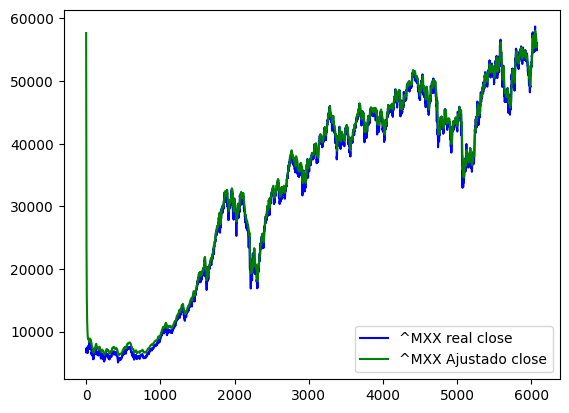

In [ ]:
plt.plot(actual_prices,color="blue",label=f"{company} real close")
plt.plot(predicted_prices,color="green",label=f"{company} Ajustado close")
plt.legend()
plt.show()

In [ ]:
rentability = 1
for i in range(1,len(actual_prices)):
  if predicted_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

print((rentability-1)*100,"%")

674.2613347998548 %


In [ ]:
model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
from graphviz import Digraph
dot = Digraph(comment='Neural Network')
dot.node('A', 'Retornos_IPC')
dot.node('B', 'Hidden Layer 1000'), dot.node('C', 'Hidden Layer 100'), dot.node('D', 'Hidden Layer 10')
dot.node('E', 'Valor_Retorno')
dot.edges(['AB', 'BC', 'CD', 'DE'])
dot.render('neural_network.gv', view=True)

'neural_network.gv.pdf'

In [ ]:
dot = Digraph(comment='model')
dot.render('neural_network.gv', view=True)

'neural_network.gv.pdf'

In [ ]:
print(x_train.shape[1])

60


In [ ]:
predictions = model.predict(model)


ValueError: Failed to find data adapter that can handle input: <class 'keras.src.engine.sequential.Sequential'>, <class 'NoneType'>